<a href="https://colab.research.google.com/github/lisya/ML_in_business/blob/lesson04/dz4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

Читаем данные

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Notebooks/ML_in_business/4/hw/data.csv')
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


Переименуем колонки и приведем колонку 'treatment'  бинарному виду.

In [4]:
df.rename(columns={'offer':'treatment', 'conversion':'target'}, inplace=True)

In [5]:
df['treatment'] = np.where(df['treatment']=='No Offer', 0, 1)

In [6]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0


Для удобства заведем переменные

In [7]:
dataset = df.drop(columns=['treatment','target'])
target = df['target']
treatment = df['treatment']

Разобъем данные на тренировочную и тестовую выборки

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val, treat_train, treat_val = train_test_split(
    dataset, target, treatment, test_size=0.5, random_state=42
)

Выберем категориальные переменные для кэтбуста

In [9]:
cat_features = X_train.select_dtypes(include='object').columns.tolist()
print(cat_features)

['zip_code', 'channel']


In [10]:
models_results = {
    'approach': [],
    'uplift@20%': [],
    'uplift@10%': []
}

**Одна модель с признаком коммуникации**

In [11]:
# !pip install scikit-uplift catboost==0.22 category_encoders==2.1.0 -U

In [12]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

models_results['approach'].append('SoloModel')

# Uplift 20%
sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
models_results['uplift@20%'].append(sm_score)

# Uplift 10%
sm_score = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)
models_results['uplift@10%'].append(sm_score)

**Трансформация классов**

In [13]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

models_results['approach'].append('ClassTransformation')

# Uplift 20%
ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)
models_results['uplift@20%'].append(ct_score)

# Uplift 10%
ct_score = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)
models_results['uplift@10%'].append(ct_score)

It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.


**Две независимые модели**

In [14]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

models_results['approach'].append('TwoModels')

# Uplift 20%
tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)
models_results['uplift@20%'].append(tm_score)

# Uplift 10%
tm_score = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)
models_results['uplift@10%'].append(tm_score)

**Результат**

In [15]:
pd.DataFrame(data=models_results)

,approach,uplift@20%,uplift@10%
0,SoloModel,0.075141,0.088825
1,ClassTransformation,0.076603,0.087014
2,TwoModels,0.076473,0.089729


**UpliftTreeClassifier**

Для дерева преобразуем категориальные признаки с помощью OHE

In [17]:
dummy_zip_code = pd.get_dummies(X_train['zip_code'], prefix='zip_code')
dummy_channel = pd.get_dummies(X_train['channel'], prefix='channel')

In [18]:
X_train_tree = pd.concat([X_train.drop(columns=['zip_code', 'channel']),dummy_channel, dummy_zip_code],axis=1)
features = [col for col in X_train_tree]

In [19]:
# !pip install causalml

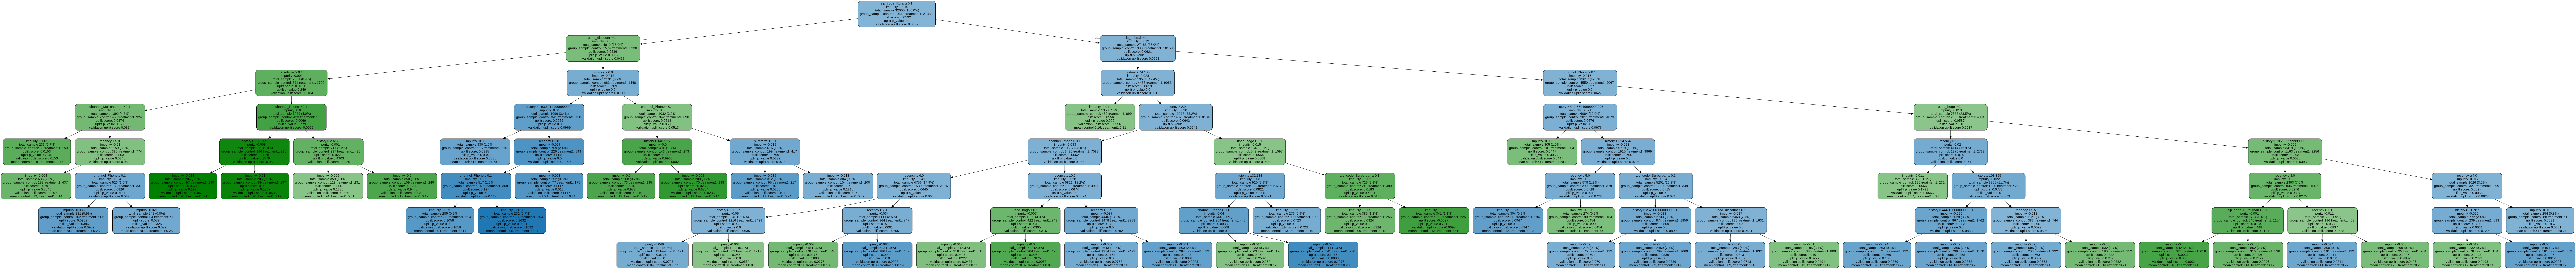

In [20]:
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

Насколько я понял разбиение ноды дерева происходит таким образом чтобы максимизировать разницу аплифта до разбиения и после него.
После того как дерево построилось, мы смотрим в каких термальных узлах значение аплифта наибольшие.Это означает что пользователи попавшие в эти узлы, увеличат нам метрику, если к ним применить воздействие.  
Например в нашей модели один из термальных листов имеет значение аплифта 0.095 а другой 0.0016. Это значит что воздействие на пользователей во втором листе лучше не производить, т.к. мы лишь потратим средства на аплифт.

Хотя может я что-то не так понял)